In [ ]:
'''Brief plan'''
# https://miro.com/app/board/uXjVNtINnFo=/?share_link_id=904921768394

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt

# np.random.seed(42)  # For reproducibility

# Market Parameters
# Define the MDP parameters
T = 100  # Total number of time steps
states = []  # Initialize an empty list to store states
rewards = []  # Initialize an empty list to store rewards

# Initialize the state of the market maker
inventory = 0  # Inventory of market maker
spread = 2  # Initial spread between ask and bid prices

# Initialize the fundamental value of the asset
fundamental_value = 100  # Initial fundamental value

lambda_i = 0.526  # Probability of informed trader arrival
lambda_u = 0.132  # Probability of uninformed trader arrival
lambda_p = 0.105  # Probability of price jump

events = ['informed', 'uninformed_buy', 'uninformed_sell', 'jump_up', 'jump_down']
probabilities = [lambda_i, lambda_u, lambda_u, lambda_p, lambda_p]

# MDP Parameters
wpro = 0.8  # Weight for profit
winv = 0.1  # Weight for inventory
wspr = 0.1  # Weight for spread

# RL Parameters
kappa = 0.8  # Given risk-aversion parameter
alpha = 0.004  # Learning rate
gamma = 0.9  # Discount factor
tau = 0.75  # Softmax parameter
epsilon = 0.1  # Exploration rate for epsilon-greedy policy

# Define possible actions for the market maker
# Each action is a tuple (delta_ask, delta_bid)
# Positive values indicate an increase, negative values indicate a decrease, and zero indicates no change

# (increase/decrease/no_change in ask_price, same for bid_price)
actions = [
    (delta_ask, delta_bid) for delta_ask in [-1, 0, 1] for delta_bid in [-1, 0, 1]
]
actions

[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]

# MDP: evnironment <-> agent

In [ ]:
def simulate_market(market_maker, policy_type, steps=100, sarsa_type='double'):
    # market_maker = None
    # if(s == "SARSA"):
    #     market_maker = MarketMaker()
    # elif s == "DOUBLE_SARSA":
    #     market_maker = MarketMaker_DOUBLE_SARSA()

    informed_traders = [TradingAgent(is_informed=True) for _ in range(1)]
    uninformed_traders = [TradingAgent(is_informed=False) for _ in range(1)]


    data = []
    for step in range(steps):

        next_reward = market_maker.reward
        state = market_maker.state
        action = market_maker.action
        market_maker.update_quotes(action)
        market_maker.calc_state(market_maker.inventory, market_maker.ask_price, market_maker.bid_price)
        next_state = market_maker.state
        next_action = market_maker.choose_action(next_state, policy_type=policy_type)
        if sarsa_type == 'double':
            market_maker.update_Q_double(state, action, next_reward, next_state, next_action)
        else:
            market_maker.update_Q(state, action, next_reward, next_state, next_action)
        next_reward = market_maker.get_reward()


        event = np.random.choice(events, p=probabilities)
        # Implement event outcomes
        if event == 'jump_up' or event == 'jump_down':
            jump_direction = 1 if event == 'jump_up' else -1
            # Update fundamental value with a jump
            market_maker.fundamental_value += jump_direction
        # Informed agent decision
        elif event == 'informed':
            for trader in informed_traders:
                trade_action, trade_volume = trader.decide_trade(market_maker, market_maker.fundamental_value)
                market_maker.execute_trade(trade_volume, trade_action)
        # Uninformed agent decision
        else:
            for trader in uninformed_traders:
                trade_action, trade_volume = trader.decide_trade(market_maker, market_maker.fundamental_value)
                market_maker.execute_trade(trade_volume, trade_action)

        data.append({
            'profit': market_maker.profit,
            'inventory': market_maker.inventory,
            'bid_price': market_maker.bid_price,
            'ask_price': market_maker.ask_price,
            'fundamental_value': market_maker.fundamental_value,
        })

    df = pd.DataFrame(data)
    return df

# **SARSA**

In [ ]:
import numpy as np

def softmax_probability(q_values, tau):
    """Computes the softmax probability for each action."""
    exp_q = np.exp(q_values - np.max(q_values)) / tau
    probabilities = exp_q / np.sum(exp_q)
    if np.isnan(probabilities).any():  # Check for NaN values
        probabilities = np.ones_like(probabilities) / len(probabilities)  # Set all probabilities to equal if NaN exists
    return probabilities

def mihatssch_neuneier(x):
    if x > 0:
      x = (1 - kappa) * x
    else:
      x = (1 + kappa) * x
    return x

class MarketMaker:
    def __init__(self, fundamental_value=100, reward=0, state=(0, 2)):
        self.fundamental_value = fundamental_value
        self.bid_price = fundamental_value - 1
        self.ask_price = fundamental_value + 1
        self.last_trade_price = 0
        self.inventory = 0
        self.profit = 0
        self.state = state
        self.action = (0, 0)
        self.Q1 = {}
        self.Q2 = {}
        self.reward = 0

    def update_quotes(self, action):
        self.ask_price += action[1]
        self.bid_price += action[0]

    def calc_state(self, inventory, ask_price, bid_price):
        self.state = (inventory, ask_price - bid_price)

    def calc_state(self, inventory, ask_price, bid_price):
        self.state = (inventory, ask_price - bid_price)

    def choose_action(self, state, policy_type='epsilon_greedy'):
        if policy_type == 'softmax':
            q_values = [(self.Q1.get((state, a), 0) + self.Q2.get((state, a), 0))/2 for a in actions]
            probabilities = softmax_probability(q_values, tau)
            action_index = np.random.choice(range(len(actions)), p=probabilities)
            action = actions[action_index]
        elif policy_type == 'epsilon_greedy':
            if np.random.rand() < epsilon:
                action_index = np.random.choice(range(len(actions)))  # Explore by selecting a random index
                action = actions[action_index]
            else:
                # Exploit by selecting the action with the highest Q-value
                q_values = {a: (self.Q1.get((state, a), 0) + self.Q2.get((state, a), 0))/2 for a in actions}
                max_q_value = max(q_values, key=q_values.get, default=None)
                if max_q_value is not None:
                    # Filter actions with the maximum Q-value
                    max_actions = [action for action, q_value in q_values.items() if q_value == q_values[max_q_value]]
                    # Randomly choose among the actions with the maximum Q-value to avoid deterministic tie-breaking
                    if max_actions:
                        action_index = np.random.choice(range(len(max_actions)))
                        action = max_actions[action_index]
                    else:
                        # If no actions have been taken yet, choose randomly
                        action_index = np.random.choice(range(len(actions)))
                        action = actions[action_index]
                else:
                    # Default to random choice if all Q-values are uninitialized
                    action_index = np.random.choice(range(len(actions)))
                    action = actions[action_index]
        else:
            raise ValueError("Unsupported policy type")

        return action


    def update_Q(self, state, action, reward, next_state, next_action):
        current_q = self.Q.get((state, action), 0)
        next_q = self.Q.get((next_state, next_action), 0)
        self.Q[(state, action)] = current_q + alpha * (reward + gamma * next_q - current_q)
        self.state, self.action = next_state, next_action

    def update_Q_double(self, state, action, reward, next_state, next_action):
        current_q1 = self.Q1.get((state, action), 0)
        current_q2 = self.Q2.get((state, action), 0)

        next_q1 = self.Q1.get((next_state, next_action), 0)
        next_q2 = self.Q2.get((next_state, next_action), 0)

        var1 = reward + gamma * next_q2 - current_q1
        var2 = reward + gamma * next_q1 - current_q2

        self.Q1[(state, action)] = current_q1 + alpha * mihatssch_neuneier(var1)
        self.Q2[(state, action)] = current_q2 + alpha * mihatssch_neuneier(var2)
        self.state, self.action = next_state, next_action

    def execute_trade(self, trade_volume, trade_type):
        if trade_type == 'buy':
            self.inventory -= trade_volume
            self.profit -= (self.fundamental_value - self.bid_price)
        elif trade_type == 'sell':
            self.inventory += trade_volume
            self.profit += (self.ask_price - self.fundamental_value)

    def reward(self):
        delta_profit = self.profit

        # Calculate the immediate reward
        immediate_reward = wpro * delta_profit - winv * abs(self.inventory) - wspr * (self.ask_price - self.bid_price)
        return immediate_reward

# **Informed/Uninformed Traders**

In [ ]:
class TradingAgent:
    def __init__(self, is_informed):
        self.is_informed = is_informed

    def decide_trade(self, market_maker, fundamental_value, uninformed_action=None):
        if self.is_informed:
            if fundamental_value > market_maker.ask_price:
                return ('buy', 1)  # Buy if fundamental value is higher than ask price
            elif fundamental_value < market_maker.bid_price:
                return ('sell', 1)  # Sell if fundamental value is lower than bid price
            else:
                return ('hold', 0)  # Hold if no opportunity
        else:
            if uninformed_action == 'uninformed_sell':
                return ('sell', 1)
            else:
                return ('buy', 1)

# Experiments

## Figure 2

**The evolution over time of metrics for risk-sensitive Double SARSA with softmax, A4**

In [ ]:
%%time
import matplotlib.pyplot as plt

episode_numbers = [25, 100, 500, 3250, 3500, 3750]
fig, axs = plt.subplots(3, len(episode_numbers), figsize=(18, 6))  # 3 rows for types of plots, N columns for episodes

# market_maker = MarketMaker_DOUBLE_SARSA()

for episode in range(4000):
    if episode != 0:
        reward = market_maker.reward
        state = market_maker.state
        market_maker = MarketMaker(100, reward, state)
    else:
        market_maker = MarketMaker()
    df_episode = simulate_market(market_maker, "softmax", steps=250, sarsa_type='double')

    if episode in episode_numbers:
        i = episode_numbers.index(episode)
        # Fundamental Value and Spread
        axs[0, i].plot(df_episode.index, df_episode['fundamental_value'], label='Fundamental Value')
        axs[0, i].fill_between(df_episode.index, df_episode['bid_price'], df_episode['ask_price'], color='gray', alpha=0.3, label='Spread')
        axs[0, i].set_title(f'Episode {episode}')
        axs[0, i].legend()

        # Profit
        axs[1, i].plot(df_episode.index, df_episode['profit'], label='Profit', color='green')
        axs[1, i].legend()

        # Inventory
        axs[2, i].plot(df_episode.index, df_episode['inventory'], label='Inventory', color='red')
        axs[2, i].legend()

plt.tight_layout()
plt.show()

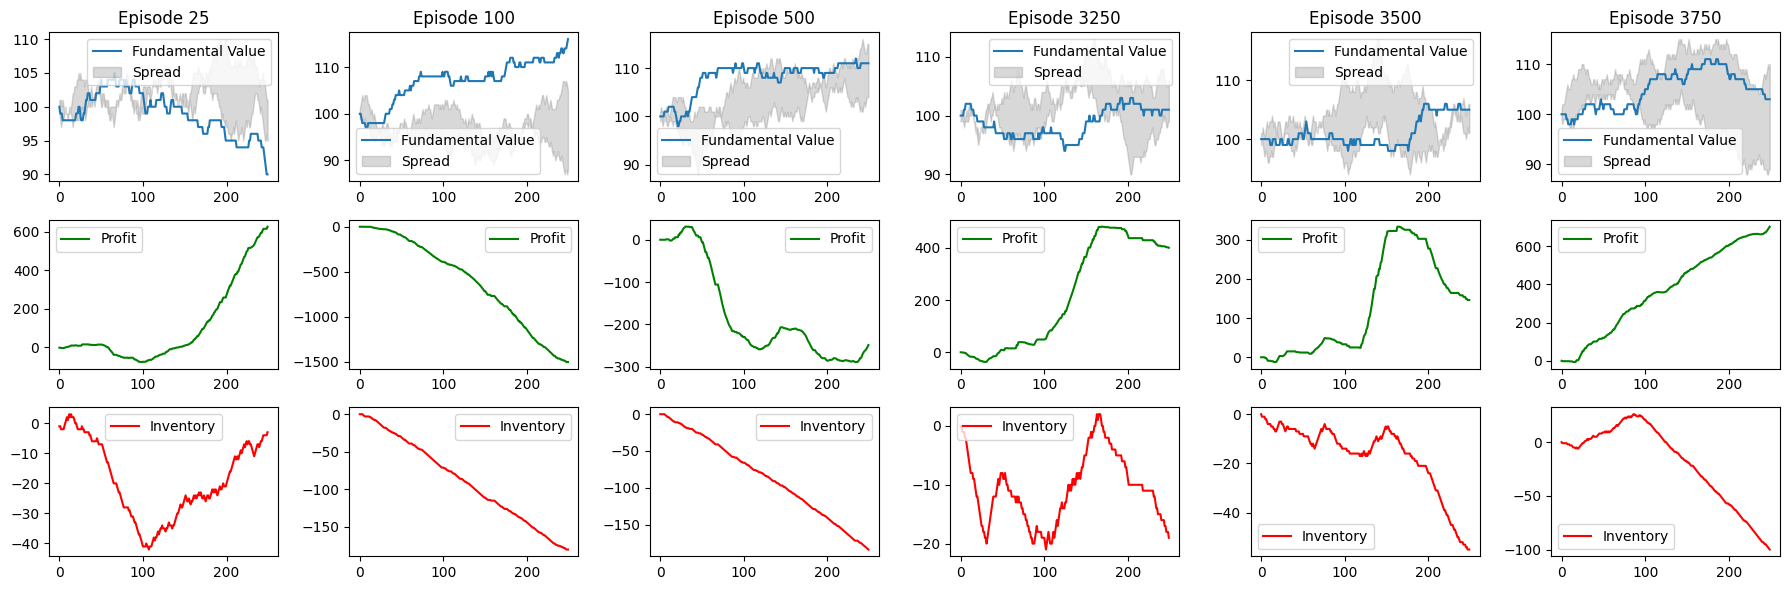

## Figure 3

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

def plot_strategy_performance(strategy, policy, episodes=4000, steps_per_episode=250):
    avg_abs_deviation_df = pd.DataFrame(columns=['episode', 'avg_abs_deviation', 'inventory_level', 'expected_profit', 'avg_episodic_spread'])
    x = 1
    inventory_data, profit_data, spread_data = {}, {}, {}

    for episode in range(episodes):
        df_episode = simulate_market(strategy, policy, steps_per_episode)
        avg_abs_deviation = ((df_episode['ask_price'] - df_episode['fundamental_value']).abs() + (df_episode['bid_price'] - df_episode['fundamental_value']).abs()).mean()/x
        avg_episodic_spread = ((df_episode['ask_price'] - df_episode['bid_price']).abs().mean())

        avg_abs_deviation_df = avg_abs_deviation_df.append({
            'episode': episode,
            'avg_abs_deviation': avg_abs_deviation,
            'inventory_level': df_episode['inventory'].mean(),
            'expected_profit': df_episode['profit'].mean(),
            'avg_episodic_spread': avg_episodic_spread
        }, ignore_index=True)
        x = ((episode + 1)**1/10)
        if episode in range(0, episodes, 250):
            inventory_data[episode] = df_episode['inventory'].tolist()
            profit_data[episode] = df_episode['profit'].tolist()
            spread_data[episode] = [avg_episodic_spread]

    # Plotting in a line
    fig, axs = plt.subplots(1, 6, figsize=(25, 5))

    # Average Absolute Price Deviation over Episodes
    axs[0].plot(avg_abs_deviation_df['episode'], avg_abs_deviation_df['avg_abs_deviation'], marker='o', linestyle='-', color='blue')
    axs[0].set_title('Avg Abs Price Deviation')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Deviation')
    axs[0].grid(True)

    # Inventory Level Boxplot
    axs[1].boxplot(inventory_data.values(), labels=[str(ep) for ep in inventory_data.keys()])
    axs[1].set_title('Inventory')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Inventory Level')
    axs[1].grid(True)

    # Inventory Hist
    axs[2].hist(avg_abs_deviation_df['inventory_level'], color='grey', bins=20)
    axs[2].set_title('Inventory Distribution')
    axs[2].set_xlabel('Expected Profit')
    axs[2].set_ylabel('Frequency')
    axs[2].grid(True)

    # Histogram for Expected Profit Distribution
    axs[3].hist(avg_abs_deviation_df['expected_profit'], color='grey', bins=20)
    axs[3].set_title('Expected Profit Distribution')
    axs[3].set_xlabel('Expected Profit')
    axs[3].set_ylabel('Frequency')
    axs[3].grid(True)

    # Profit Distribution Boxplot
    axs[4].boxplot(profit_data.values(), labels=[str(ep) for ep in profit_data.keys()])
    axs[4].set_title('Profit Distribution')
    axs[4].set_xlabel('Episode')
    axs[4].set_ylabel('Profit')
    axs[4].grid(True)

    # Average Episodic Spread Boxplot
    axs[5].boxplot(spread_data.values(), labels=[str(ep) for ep in spread_data.keys()])
    axs[5].set_title('Average Episodic Spread')
    axs[5].set_xlabel('Episode')
    axs[5].set_ylabel('Spread')
    axs[5].grid(True)

    plt.tight_layout()
    plt.show()
    return avg_abs_deviation_df

# Example usage
df_1 = plot_strategy_performance("SARSA", "epsilon_greedy", episodes=4000, steps_per_episode=250)
df_2 = plot_strategy_performance("SARSA", "softmax", episodes=4000, steps_per_episode=250)
df_3 = plot_strategy_performance("DOUBLE_SARSA", "epsilon_greedy", episodes=4000, steps_per_episode=250)
df_4 = plot_strategy_performance("DOUBLE_SARSA", "softmax", episodes=4000, steps_per_episode=250)

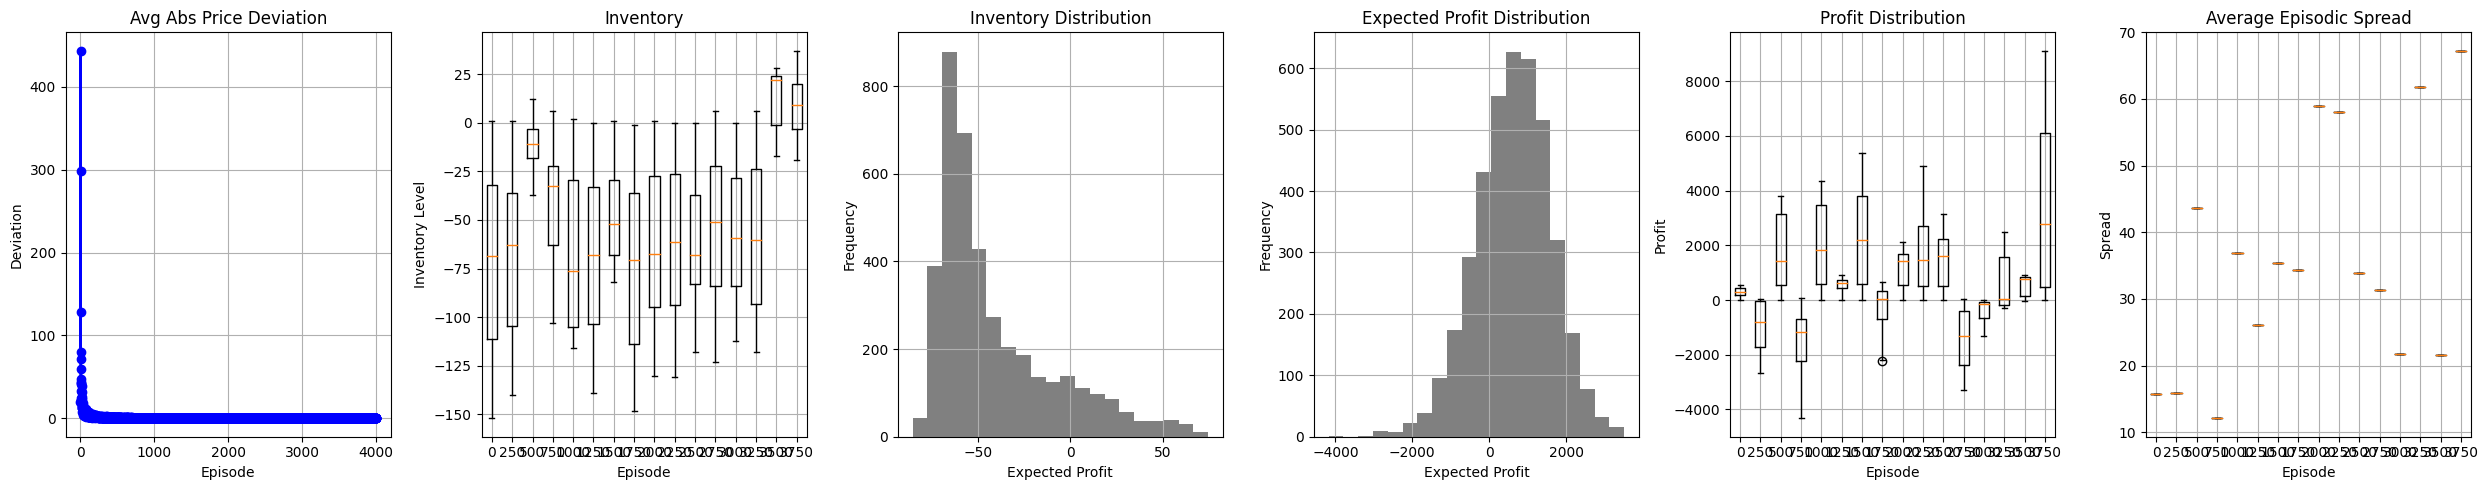
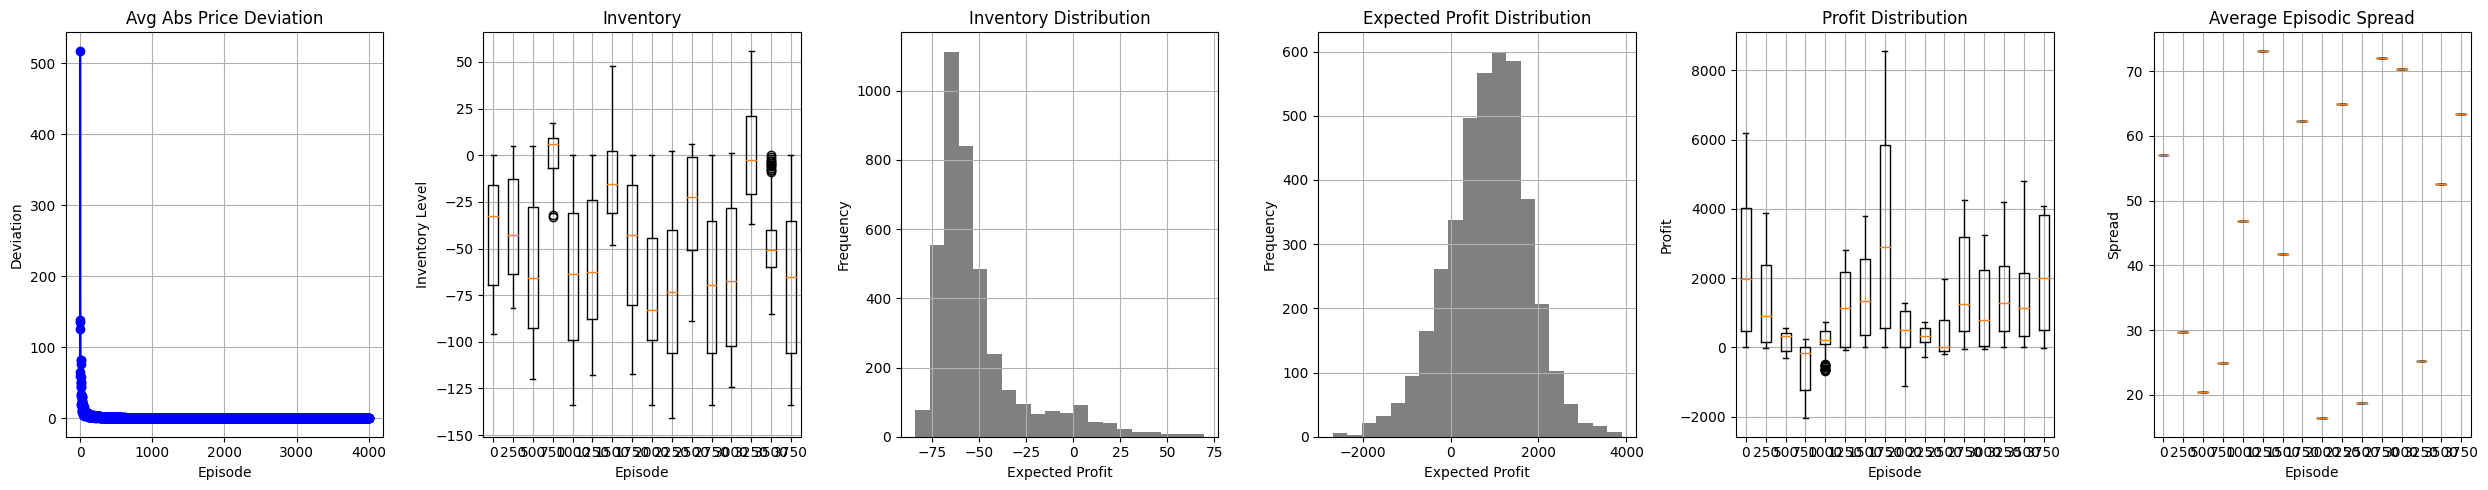
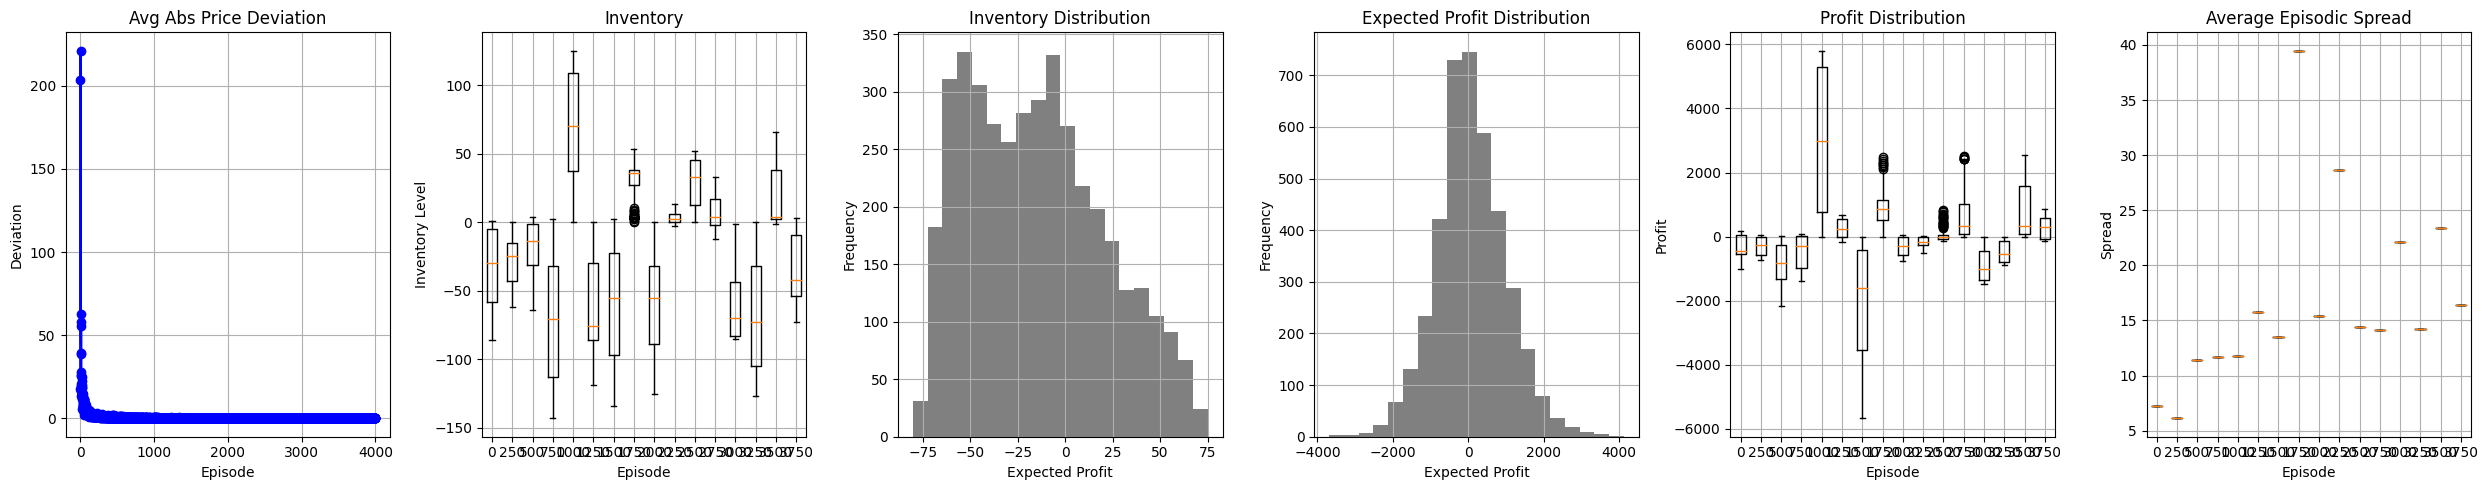
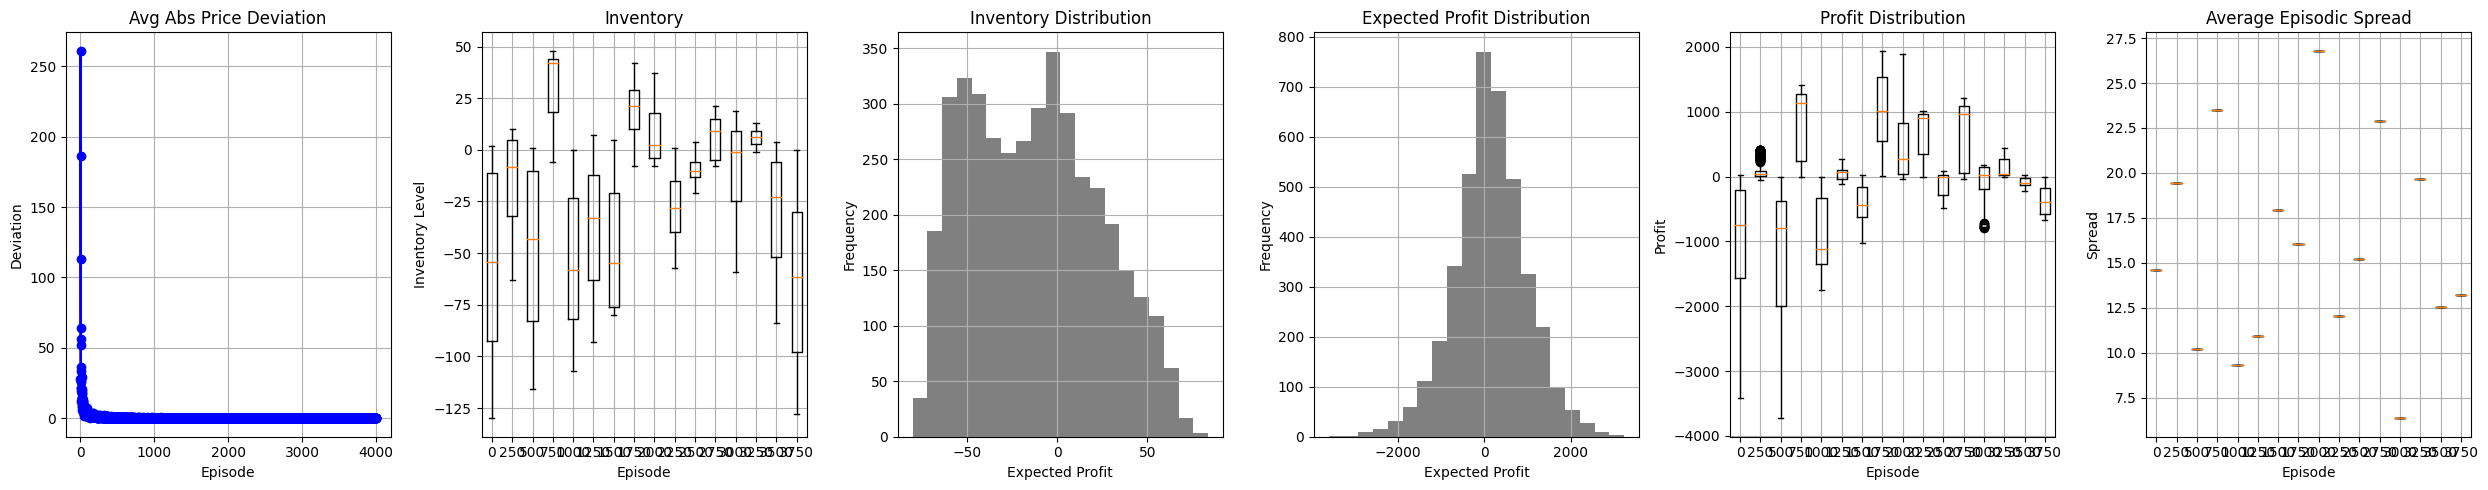

## Figure 4

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_boxplots(df_1, df_2, df_3, df_4):
    metrics = ['inventory_level', 'expected_profit', 'avg_episodic_spread']
    dataframes = [df_1, df_2, df_3, df_4]
    labels = ['Strategy 1', 'Strategy 2', 'Strategy 3', 'Strategy 4']

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

    for i, metric in enumerate(metrics):
        data_to_plot = [df[metric].values for df in dataframes]
        axs[i].boxplot(data_to_plot, patch_artist=True)
        axs[i].set_xticklabels(labels, rotation=45, ha="right")
        axs[i].set_title(f'{metric.replace("_", " ").title()}')
        axs[i].set_xlabel('Strategy')
        axs[i].set_ylabel(metric.replace("_", " ").title())
        axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

plot_combined_boxplots(df_1, df_2, df_3, df_4)

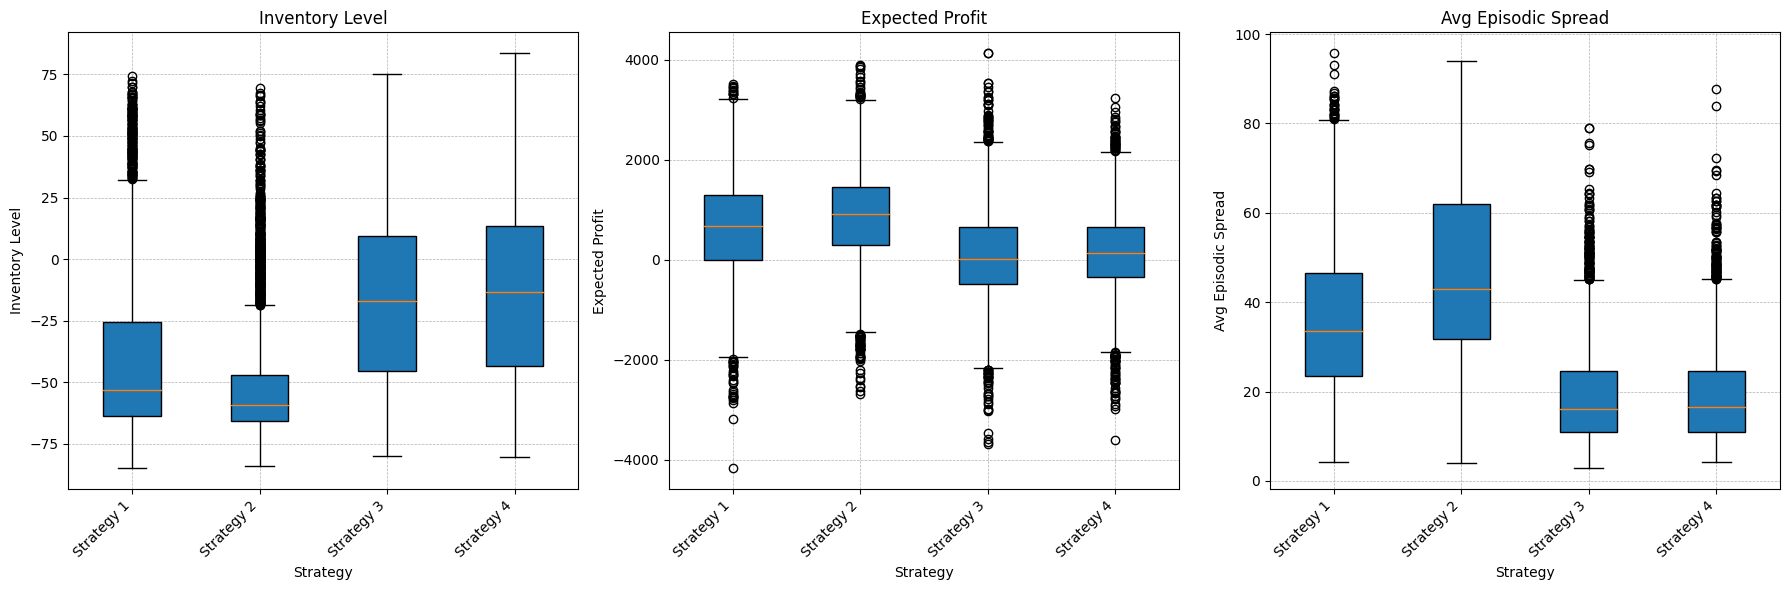